# Clustering Players Based on Scoring Profile

### Import Packages

In [1]:
import nba_api.stats.endpoints as nba
import mysql.connector
from mysql.connector import errorcode
import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = 1000

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
dbname = 'nba'
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    db = dbname
)
cursor = cnx.cursor(buffered = True)

## Preprocessing

### Import DataFrame

In [3]:
raw = pd.read_csv('initial_shot_chart_for_cluster.csv').drop('Unnamed: 0', axis=1)
raw.head()

,key_0,PLAYER_ID,SHOT_DISTANCE,SHOT_MADE_FLAG,Alley Oop Dunk Shot,Alley Oop Layup shot,Cutting Dunk Shot,Cutting Finger Roll Layup Shot,Cutting Layup Shot,Driving Bank Hook Shot,Driving Dunk Shot,Driving Finger Roll Layup Shot,Driving Floating Bank Jump Shot,Driving Floating Jump Shot,Driving Hook Shot,Driving Layup Shot,Driving Reverse Dunk Shot,Driving Reverse Layup Shot,Dunk Shot,Fadeaway Jump Shot,Finger Roll Layup Shot,Floating Jump shot,Hook Bank Shot,Hook Shot,Jump Bank Shot,Jump Shot,Layup Shot,Pullup Jump shot,Putback Dunk Shot,Putback Layup Shot,Reverse Dunk Shot,Reverse Layup Shot,Running Alley Oop Dunk Shot,Running Alley Oop Layup Shot,Running Dunk Shot,Running Finger Roll Layup Shot,Running Jump Shot,Running Layup Shot,Running Pull-Up Jump Shot,Running Reverse Dunk Shot,Running Reverse Layup Shot,Step Back Bank Jump Shot,Step Back Jump shot,Tip Dunk Shot,Tip Layup Shot,Turnaround Bank Hook Shot,Turnaround Fadeaway Bank Jump Shot,Turnaround Fadeaway shot,Turnaround Hook Shot,Turnaround Jump Shot,2PT Field Goal,3PT Field Goal,attempts_per_game
0,Aaron Brooks,201166.0,17.318841,0.405797,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.014493,0.057971,0.028986,0.144928,0.000000,0.014493,0.000000,0.043478,0.000000,0.028986,0.0,0.000000,0.000000,0.376812,0.014493,0.159420,0.000000,0.000000,0.00000,0.014493,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.0,0.014493,0.000000,0.000000,0.00000,0.550725,0.449275,3.000000
1,Aaron Gordon,203932.0,14.095954,0.433526,0.019653,0.012717,0.011561,0.001156,0.010405,0.000000,0.012717,0.006936,0.002312,0.006936,0.004624,0.065896,0.001156,0.005780,0.025434,0.025434,0.002312,0.010405,0.0,0.003468,0.003468,0.403468,0.050867,0.102890,0.008092,0.004624,0.00578,0.006936,0.009249,0.0,0.013873,0.002312,0.013873,0.017341,0.002312,0.001156,0.001156,0.001156,0.048555,0.002312,0.023121,0.0,0.003468,0.018497,0.000000,0.02659,0.604624,0.395376,14.913793
2,Aaron Harrison,1626151.0,18.927536,0.275362,0.000000,0.000000,0.000000,0.000000,0.014493,0.000000,0.000000,0.014493,0.028986,0.057971,0.000000,0.028986,0.000000,0.014493,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.637681,0.000000,0.144928,0.000000,0.014493,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.014493,0.000000,0.000000,0.014493,0.000000,0.014493,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.376812,0.623188,7.666667
3,Aaron Jackson,1628935.0,13.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.222222,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.111111,0.111111,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.555556,0.444444,9.000000
4,Abdel Nader,1627846.0,13.530201,0.335570,0.000000,0.006711,0.000000,0.000000,0.026846,0.006711,0.026846,0.026846,0.006711,0.046980,0.000000,0.174497,0.000000,0.013423,0.000000,0.020134,0.000000,0.000000,0.0,0.000000,0.000000,0.456376,0.046980,0.020134,0.000000,0.020134,0.00000,0.000000,0.000000,0.0,0.006711,0.006711,0.006711,0.013423,0.000000,0.000000,0.000000,0.000000,0.020134,0.000000,0.020134,0.0,0.006711,0.013423,0.006711,0.00000,0.563758,0.436242,3.921053


In [22]:
raw.shape

(543, 53)

### Remove who average less than 3 shot attempts per game when playing

In [23]:
list(set(raw['key_0'].values) - set(raw[raw['attempts_per_game']>= 3]['key_0'].values))

['Salah Mejri',
 'Kendrick Perkins',
 'Ryan Arcidiacono',
 'Jacob Pullen',
 'D.J. Wilson',
 'David Stockton',
 'James Webb III',
 'Jake Layman',
 'Quincy Pondexter',
 'Luis Montero',
 'James Young',
 'Erik McCree',
 'Nick Collison',
 'Ekpe Udoh',
 'Alfonzo McKinnie',
 'Jeremy Evans',
 'Joel Bolomboy',
 'Lucas Nogueira',
 'Chris Boucher',
 'Antonius Cleveland',
 'Vincent Hunter',
 'Zhou Qi',
 'Jeff Withey',
 'Scotty Hopson',
 'Derrick Walton Jr.',
 'Nate Wolters',
 'Julyan Stone',
 'Andrew Bogut',
 'Nicolas Brussino',
 'Larry Drew II',
 'Cole Aldrich',
 'Marcus Paige',
 'Luol Deng',
 'DaQuan Jeffries',
 'Furkan Korkmaz',
 'Edmond Sumner',
 'Josh McRoberts',
 'Marshall Plumlee',
 'Josh Smith',
 'Mindaugas Kuzminskas',
 'Dakari Johnson',
 'Charles Cooke',
 'Richard Jefferson',
 'DeAndre Liggins',
 'Thomas Bryant',
 'Xavier Munford',
 'Udonis Haslem',
 'Tim Quarterman',
 'Daniel Hamilton',
 'Ron Baker',
 'Reggie Hearn',
 'Jacob Wiley',
 'Vander Blue',
 'Demetrius Jackson',
 'James Michael 

In [4]:
### remove players from the data set who do not attempt more than 3 shots per game
profile17 = raw[raw['attempts_per_game']>= 3]
profile17.reset_index(drop=False, inplace=True)
profile17.shape

(461, 54)

In [25]:
profile17.columns

Index(['index', 'key_0', 'PLAYER_ID', 'SHOT_DISTANCE', 'SHOT_MADE_FLAG',
       'Alley Oop Dunk Shot', 'Alley Oop Layup shot', 'Cutting Dunk Shot',
       'Cutting Finger Roll Layup Shot', 'Cutting Layup Shot',
       'Driving Bank Hook Shot', 'Driving Dunk Shot',
       'Driving Finger Roll Layup Shot', 'Driving Floating Bank Jump Shot',
       'Driving Floating Jump Shot', 'Driving Hook Shot', 'Driving Layup Shot',
       'Driving Reverse Dunk Shot', 'Driving Reverse Layup Shot', 'Dunk Shot',
       'Fadeaway Jump Shot', 'Finger Roll Layup Shot', 'Floating Jump shot',
       'Hook Bank Shot', 'Hook Shot', 'Jump Bank Shot', 'Jump Shot',
       'Layup Shot', 'Pullup Jump shot', 'Putback Dunk Shot',
       'Putback Layup Shot', 'Reverse Dunk Shot', 'Reverse Layup Shot',
       'Running Alley Oop Dunk Shot', 'Running Alley Oop Layup Shot',
       'Running Dunk Shot', 'Running Finger Roll Layup Shot',
       'Running Jump Shot', 'Running Layup Shot', 'Running Pull-Up Jump Shot',
       'R

## EDA

### Distribution of Field Goal Percentage 2017

Text(0.5, 1.0, 'Distribution of FG% - 2017')

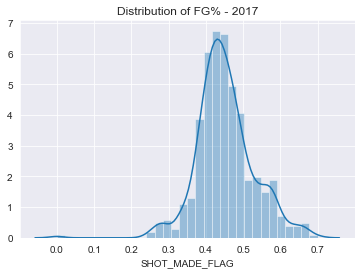

In [26]:
fig = sns.distplot(profile17['SHOT_MADE_FLAG'])
fig.set_title('Distribution of FG% - 2017')

### Distribution of Average Shot Distance 2017

Text(0.5, 1.0, 'Distribution of Average Shot Distances - 2017')

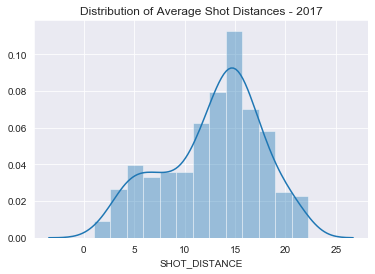

In [27]:
fig = sns.distplot(profile17['SHOT_DISTANCE'])
fig.set_title('Distribution of Average Shot Distances - 2017')

### Distribution of Percentage of 2pt FGA 2017

Text(0.5, 1.0, 'Distribution of % 2PT Attempts - 2017')

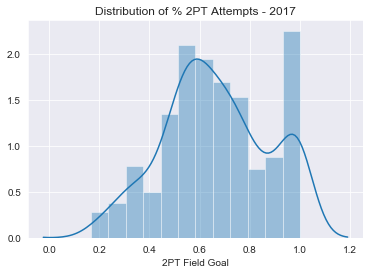

In [28]:
fig = sns.distplot(profile17['2PT Field Goal'])
fig.set_title('Distribution of % 2PT Attempts - 2017')

### Distribution of Percentage of 3pt FGA 2017

Text(0.5, 1.0, 'Distribution of % 3PT Attempts - 2017')

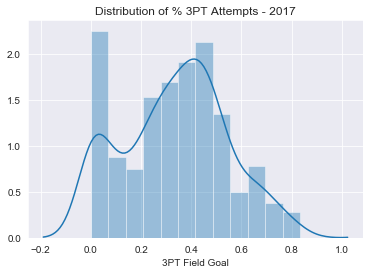

In [29]:
fig = sns.distplot(profile17['3PT Field Goal'])
fig.set_title('Distribution of % 3PT Attempts - 2017')

### Distribution of FGA per Game

Text(0.5, 1.0, 'Distribution of Average Attempts per Game - 2017')

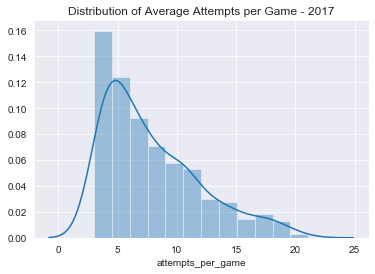

In [30]:
fig = sns.distplot(profile17['attempts_per_game'])
fig.set_title('Distribution of Average Attempts per Game - 2017')

### Distribution of Percentage of Step Back Jump Shot Attempts 2017

Text(0.5, 1.0, '% of Step Back Jumpers per Player - 2017')

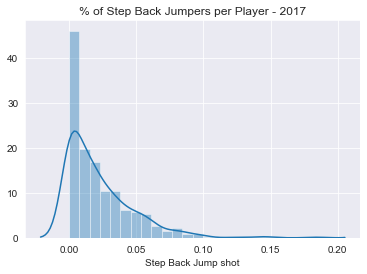

In [31]:
fig = sns.distplot(profile17['Step Back Jump shot'])
fig.set_title('% of Step Back Jumpers per Player - 2017')

### Distribution of Percentage of Jump Shots Attempted

Text(0.5, 1.0, '% of Jumpers per Player - 2017')

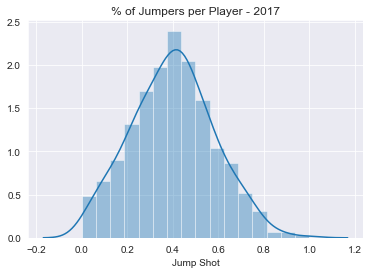

In [32]:
fig = sns.distplot(profile17['Jump Shot'])
fig.set_title('% of Jumpers per Player - 2017')

In [33]:
X.columns

NameError: name 'X' is not defined

## Clustering Model

### 3D Graph to Examine Features

In [34]:
x = profile17['attempts_per_game']
y = profile17['Step Back Jump shot']
z = profile17['2PT Field Goal']
text = profile17['key_0']
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   text = text,
                                   hoverinfo = 'text',
                                   mode='markers'
                                  )],)
fig.update_layout(scene = dict(
                    xaxis_title='attempts_per_game',
                    yaxis_title='step back %',
                    zaxis_title='2pt attempt %'))
                
                
fig.show()



### Preprocessing

In [5]:
X = profile17.drop(labels=['key_0', 'PLAYER_ID', 'index'], axis=1)

In [36]:
X.shape

(461, 51)

In [37]:
group1 = ['Alley Oop Dunk Shot',
       'Alley Oop Layup shot']

In [38]:
X.columns

Index(['SHOT_DISTANCE', 'SHOT_MADE_FLAG', 'Alley Oop Dunk Shot',
       'Alley Oop Layup shot', 'Cutting Dunk Shot',
       'Cutting Finger Roll Layup Shot', 'Cutting Layup Shot',
       'Driving Bank Hook Shot', 'Driving Dunk Shot',
       'Driving Finger Roll Layup Shot', 'Driving Floating Bank Jump Shot',
       'Driving Floating Jump Shot', 'Driving Hook Shot', 'Driving Layup Shot',
       'Driving Reverse Dunk Shot', 'Driving Reverse Layup Shot', 'Dunk Shot',
       'Fadeaway Jump Shot', 'Finger Roll Layup Shot', 'Floating Jump shot',
       'Hook Bank Shot', 'Hook Shot', 'Jump Bank Shot', 'Jump Shot',
       'Layup Shot', 'Pullup Jump shot', 'Putback Dunk Shot',
       'Putback Layup Shot', 'Reverse Dunk Shot', 'Reverse Layup Shot',
       'Running Alley Oop Dunk Shot', 'Running Alley Oop Layup Shot',
       'Running Dunk Shot', 'Running Finger Roll Layup Shot',
       'Running Jump Shot', 'Running Layup Shot', 'Running Pull-Up Jump Shot',
       'Running Reverse Dunk Shot', 'Run

### Model 1- n_clusters = 15, linkage = ward

In [9]:
agg_clust = AgglomerativeClustering(n_clusters=15, linkage='ward')
assigned_clust = agg_clust.fit_predict(X)

players_with_clusters = pd.DataFrame([profile17['key_0'],assigned_clust]).T
players_with_clusters.columns = ['name', 'cluster']

for cluster in range(0,15):
    print( players_with_clusters[players_with_clusters['cluster']==cluster])
    

    
players_with_clusters.to_csv('cluster_group_3.csv')

                   name cluster
9         Alan Williams       0
14             Alex Len       0
16         Amir Johnson       0
20       Andre Roberson       0
31          Bam Adebayo       0
34      Bismack Biyombo       0
36     Boban Marjanovic       0
42       Brandan Wright       0
62        Cheick Diallo       0
65         Clint Capela       0
66          Cody Zeller       0
70    Cristiano Felicio       0
73         Damian Jones       0
86          David Nwaba       0
91       DeAndre Jordan       0
110       Deyonta Davis       0
127            Ed Davis       0
129        Emeka Okafor       0
152         Greg Monroe       0
158         Ian Mahinmi       0
167         Ivica Zubac       0
171      JaKarr Sampson       0
173        JaVale McGee       0
176         Jack Cooley       0
178       Jahlil Okafor       0
179        Jakob Poeltl       0
183       Jameel Warney       0
192       Jarrett Allen       0
214   Joffrey Lauvergne       0
215        John Collins       0
216     

In [8]:
players_with_clusters[players_with_clusters['name']=='Terry Rozier']

,name,cluster
405,Terry Rozier,4


### Model 2- n_clusters = 20, linkage = ward

In [40]:
agg_clust = AgglomerativeClustering(n_clusters=20, linkage='ward')
assigned_clust = agg_clust.fit_predict(X)

players_with_clusters2 = pd.DataFrame([profile17['key_0'],assigned_clust]).T
players_with_clusters2.columns = ['name', 'cluster']

for cluster in range(0,20):
    print( players_with_clusters2[players_with_clusters2['cluster']==cluster])

                  name cluster
3        Aaron Jackson       0
39   Bogdan Bogdanovic       0
40    Bojan Bogdanovic       0
48         Brook Lopez       0
51         Buddy Hield       0
56       Cameron Payne       0
69        Courtney Lee       0
75          Damion Lee       0
78    Danilo Gallinari       0
83         Dario Saric       0
85     Darren Collison       0
95     DeMarre Carroll       0
111      Dillon Brooks       0
119     Draymond Green       0
134     Ersan Ilyasova       0
137     Frank Kaminsky       0
168         J.J. Barea       0
203        Jeremy Lamb       0
236    Josh Richardson       0
249       Kelly Olynyk       0
250    Kelly Oubre Jr.       0
253      Kent Bazemore       0
273   Lance Stephenson       0
279         Lonzo Ball       0
297  Marcus Morris Sr.       0
298       Marcus Smart       0
300      Mario Hezonja       0
303    Markieff Morris       0
317         Mike James       0
327       Myles Turner       0
336     Nikola Mirotic       0
344    O

## Rerunning of Clustering Model Using Grouped Action Types

In [41]:
grouped = pd.read_csv('grouped_shot_chart_for_cluster.csv').drop('Unnamed: 0', axis=1)
grouped.head()

,key_0,player_id,avg_shot_distance_all,field_goal_percentage_all,percent_shots_Alley_Oop,percent_shots_Created_Jumper,percent_shots_Dunk,percent_shots_Floater,percent_shots_Hook_Shot,percent_shots_Jump_Shot,percent_shots_Layup,percent_shots_Rebound_Shot,percent_shots_2PTA,percent_shots_3PTA,avg_distance_Alley-Oop,avg_distance_Created Jumper,avg_distance_Dunk,avg_distance_Floater,avg_distance_Hook Shot,avg_distance_Jump Shot,avg_distance_Layup,avg_distance_Rebound Shot,avg_X_loc_Alley-Oop,avg_X_loc_Created Jumper,avg_X_loc_Dunk,avg_X_loc_Floater,avg_X_loc_Hook Shot,avg_X_loc_Jump Shot,avg_X_loc_Layup,avg_X_loc_Rebound Shot,avg_Y_loc_Alley-Oop,avg_Y_loc_Created Jumper,avg_Y_loc_Dunk,avg_Y_loc_Floater,avg_Y_loc_Hook Shot,avg_Y_loc_Jump Shot,avg_Y_loc_Layup,avg_Y_loc_Rebound Shot,field_goal_percentage_Alley-Oop,field_goal_percentage_Created Jumper,field_goal_percentage_Dunk,field_goal_percentage_Floater,field_goal_percentage_Hook Shot,field_goal_percentage_Jump Shot,field_goal_percentage_Layup,field_goal_percentage_Rebound Shot,attempts_per_game
0,Aaron Brooks,201166.0,17.318841,0.405797,0.000000,0.217391,0.000000,0.101449,0.028986,0.420290,0.231884,0.000000,0.550725,0.449275,NaN,20.533333,NaN,9.142857,7.000000,26.931034,1.750000,NaN,NaN,19.800000,NaN,-48.000000,59.000000,-7.379310,1.250000,NaN,NaN,167.200000,NaN,55.571429,39.500000,195.413793,17.375000,NaN,NaN,0.466667,NaN,0.142857,1.0,0.379310,0.437500,NaN,3.000000
1,Aaron Gordon,203932.0,14.095954,0.433526,0.041618,0.203468,0.091329,0.019653,0.008092,0.446243,0.151445,0.038150,0.604624,0.395376,1.0,17.982955,1.189873,7.764706,4.571429,21.891192,2.076336,0.363636,-0.138889,-19.409091,-0.189873,-12.941176,0.285714,-23.759067,-1.106870,-0.393939,11.083333,141.619318,12.810127,66.470588,34.285714,158.448187,21.183206,-0.545455,0.861111,0.363636,0.848101,0.176471,0.0,0.318653,0.473282,0.757576,14.913793
2,Aaron Harrison,1626151.0,18.927536,0.275362,0.000000,0.159420,0.014493,0.086957,0.000000,0.637681,0.086957,0.014493,0.376812,0.623188,NaN,16.909091,1.000000,8.833333,NaN,24.045455,1.166667,1.000000,NaN,46.727273,-2.000000,23.166667,NaN,-34.272727,-7.000000,-19.000000,NaN,134.272727,11.000000,60.500000,NaN,138.022727,13.166667,4.000000,NaN,0.363636,1.000000,0.166667,NaN,0.204545,0.500000,1.000000,7.666667
3,Aaron Jackson,1628935.0,13.000000,0.333333,0.000000,0.111111,0.000000,0.111111,0.000000,0.333333,0.444444,0.000000,0.555556,0.444444,NaN,24.000000,NaN,8.000000,NaN,24.666667,2.750000,NaN,NaN,-147.000000,NaN,65.000000,NaN,-60.000000,14.250000,NaN,NaN,202.000000,NaN,52.000000,NaN,156.666667,26.250000,NaN,NaN,1.000000,NaN,1.000000,NaN,0.000000,0.250000,NaN,9.000000
4,Abdel Nader,1627846.0,13.530201,0.335570,0.006711,0.060403,0.053691,0.053691,0.006711,0.483221,0.295302,0.040268,0.563758,0.436242,1.0,16.555556,1.375000,6.625000,9.000000,23.083333,2.909091,0.500000,-5.000000,-31.666667,0.625000,16.625000,-76.000000,29.583333,0.409091,3.500000,15.000000,151.111111,13.250000,51.000000,52.000000,130.680556,24.022727,0.833333,0.000000,0.222222,0.750000,0.375000,0.0,0.319444,0.295455,0.500000,3.921053


In [42]:
grouped.columns

Index(['key_0', 'player_id', 'avg_shot_distance_all',
       'field_goal_percentage_all', 'percent_shots_Alley_Oop',
       'percent_shots_Created_Jumper', 'percent_shots_Dunk',
       'percent_shots_Floater', 'percent_shots_Hook_Shot',
       'percent_shots_Jump_Shot', 'percent_shots_Layup',
       'percent_shots_Rebound_Shot', 'percent_shots_2PTA',
       'percent_shots_3PTA', 'avg_distance_Alley-Oop',
       'avg_distance_Created Jumper', 'avg_distance_Dunk',
       'avg_distance_Floater', 'avg_distance_Hook Shot',
       'avg_distance_Jump Shot', 'avg_distance_Layup',
       'avg_distance_Rebound Shot', 'avg_X_loc_Alley-Oop',
       'avg_X_loc_Created Jumper', 'avg_X_loc_Dunk', 'avg_X_loc_Floater',
       'avg_X_loc_Hook Shot', 'avg_X_loc_Jump Shot', 'avg_X_loc_Layup',
       'avg_X_loc_Rebound Shot', 'avg_Y_loc_Alley-Oop',
       'avg_Y_loc_Created Jumper', 'avg_Y_loc_Dunk', 'avg_Y_loc_Floater',
       'avg_Y_loc_Hook Shot', 'avg_Y_loc_Jump Shot', 'avg_Y_loc_Layup',
       'avg_Y_

### Add in features from detailed scoring box scores

In [43]:
stmt = "SELECT * from nba.scoring"
cursor.execute(stmt)
scores = cursor.fetchall()

field_names = [i[0] for i in cursor.description]
scoring = pd.DataFrame(scores)
scoring.columns = field_names

In [44]:
scoring.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM
0,0021800906,1610612755,PHI,Philadelphia,202710,Jimmy Butler,F,,34:59,0.875,0.125,0.909,0.364,0.000,0.000,0.091,0.000,0.545,0.600,0.400,0.000,0.000,0.60,0.40
1,0021800906,1610612755,PHI,Philadelphia,202699,Tobias Harris,F,,38:50,0.500,0.500,0.552,0.069,0.207,0.069,0.241,0.000,0.483,0.375,0.625,0.500,0.500,0.40,0.60
2,0021800906,1610612755,PHI,Philadelphia,1628413,Jonah Bolden,C,,18:13,0.444,0.556,0.667,0.000,0.333,0.222,0.000,0.000,0.667,0.667,0.333,1.000,0.000,0.75,0.25
3,0021800906,1610612755,PHI,Philadelphia,200755,JJ Redick,G,,35:37,0.438,0.563,0.250,0.250,0.563,0.188,0.188,0.188,0.000,1.000,0.000,0.333,0.667,0.60,0.40
4,0021800906,1610612755,PHI,Philadelphia,1627732,Ben Simmons,G,,34:05,0.938,0.063,1.000,0.000,0.000,0.571,0.000,0.286,1.000,0.000,1.000,0.000,0.000,0.00,1.00


#### Keep 2017 games only

In [45]:
scoring17 = scoring[scoring.GAME_ID.str.contains('00217')]
scoring17.shape

(31029, 24)

#### Drop games where a guy does not play

In [46]:
rows_to_drop = scoring17[scoring17.MIN.isna()==True]
rows_to_drop.MIN.value_counts(dropna=False)
scoring17.drop(rows_to_drop.index)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM
24,0021700946,1610612740,NOP,New Orleans,202734,E'Twaun Moore,F,,30:27,0.714,0.286,0.857,0.286,0.000,0.571,0.143,0.000,0.571,1.000,0.000,0.0,0.0,1.000,0.000
25,0021700946,1610612740,NOP,New Orleans,203076,Anthony Davis,F,,36:34,0.947,0.053,0.783,0.000,0.000,0.087,0.217,0.087,0.783,0.667,0.333,0.0,0.0,0.667,0.333
26,0021700946,1610612740,NOP,New Orleans,202703,Nikola Mirotic,C,,30:57,0.267,0.733,0.167,0.083,0.750,0.542,0.083,0.083,0.083,0.500,0.500,1.0,0.0,0.875,0.125
27,0021700946,1610612740,NOP,New Orleans,201950,Jrue Holiday,G,,32:07,0.842,0.158,0.667,0.133,0.200,0.100,0.133,0.067,0.533,0.200,0.800,0.5,0.5,0.250,0.750
28,0021700946,1610612740,NOP,New Orleans,200765,Rajon Rondo,G,,32:04,0.571,0.429,0.429,0.286,0.429,0.000,0.143,0.071,0.143,0.000,1.000,0.5,0.5,0.200,0.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67810,0021701024,1610612763,MEM,Memphis,1628424,Kobi Simmons,,,7:02,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000
67811,0021701024,1610612763,MEM,Memphis,202718,Chandler Parsons,,,5:35,0.667,0.333,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000
67812,0021701024,1610612763,MEM,Memphis,1627738,Deyonta Davis,,,14:39,1.000,0.000,1.000,0.000,0.000,0.333,0.000,0.333,1.000,0.667,0.333,0.0,0.0,0.667,0.333
67813,0021701024,1610612763,MEM,Memphis,1627782,Wayne Selden,,,19:24,0.000,1.000,0.000,0.000,0.750,0.000,0.250,0.000,0.000,0.000,0.000,1.0,0.0,1.000,0.000


#### Calculate per game averages for each player

In [47]:
scoring_groups = scoring17.groupby('PLAYER_NAME').agg('mean')
scoring_groups.head(50)

,TEAM_ID,PLAYER_ID,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM
PLAYER_NAME,,,,,,,,,,,,,,,,,
Aaron Brooks,1.610613e+09,201166.0,0.410344,0.308406,0.281250,0.165625,0.195312,0.005219,0.085938,0.068219,0.115625,0.031250,0.375000,0.234375,0.046875,0.195312,0.304688
Aaron Gordon,1.610613e+09,203932.0,0.600552,0.399466,0.503672,0.104569,0.340793,0.148138,0.155638,0.152121,0.399138,0.524310,0.475690,0.694828,0.184483,0.600897,0.399103
Aaron Harrison,1.610613e+09,1626151.0,0.363000,0.637000,0.338889,0.109667,0.351889,0.213222,0.198111,0.076556,0.229111,0.166667,0.500000,0.555556,0.000000,0.507444,0.381444
Aaron Holiday,1.610613e+09,1628988.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron Jackson,1.610613e+09,1628935.0,0.556000,0.444000,0.500000,0.000000,0.375000,0.000000,0.125000,0.000000,0.500000,0.500000,0.500000,0.000000,1.000000,0.333000,0.667000
Abdel Nader,1.610613e+09,1627846.0,0.438000,0.353667,0.238375,0.027771,0.273104,0.079458,0.134354,0.143958,0.210604,0.121521,0.253479,0.364583,0.010417,0.357646,0.184021
Adreian Payne,1.610613e+09,203940.0,0.416800,0.183200,0.294200,0.140000,0.145800,0.000000,0.160000,0.117200,0.154200,0.500000,0.100000,0.400000,0.000000,0.533400,0.066600
Al Horford,1.610613e+09,201143.0,0.691028,0.308986,0.584181,0.149292,0.318722,0.039806,0.097083,0.131486,0.434903,0.547083,0.425139,0.736111,0.041667,0.672431,0.327569
Al Jefferson,1.610613e+09,2744.0,0.932139,0.012306,0.786167,0.219000,0.000000,0.013111,0.102722,0.115111,0.567111,0.503028,0.385861,0.000000,0.000000,0.503028,0.385861


#### Drop repetitive columns

In [48]:
keep_cols3 = ['PCT_PTS_2PT',
       'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT',
       'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM',
       'PCT_AST_3PM', 'PCT_UAST_3PM']
to_merge = scoring_groups[keep_cols3]



#### Merge with custom shot groups

In [49]:
df = pd.merge(left= grouped, right=to_merge, left_on='key_0', right_on=to_merge.index)
df.index = df.key_0
df.drop('key_0', axis=1, inplace=True)

### Clustering 2.0

#### Drop players who do not average at least 5 shot attempts per game

In [50]:
df2 = df[df['attempts_per_game']>= 5]
df2.reset_index(drop=False, inplace=True)
df2.shape

(323, 58)

In [51]:
df2.head()

,key_0,player_id,avg_shot_distance_all,field_goal_percentage_all,percent_shots_Alley_Oop,percent_shots_Created_Jumper,percent_shots_Dunk,percent_shots_Floater,percent_shots_Hook_Shot,percent_shots_Jump_Shot,percent_shots_Layup,percent_shots_Rebound_Shot,percent_shots_2PTA,percent_shots_3PTA,avg_distance_Alley-Oop,avg_distance_Created Jumper,avg_distance_Dunk,avg_distance_Floater,avg_distance_Hook Shot,avg_distance_Jump Shot,avg_distance_Layup,avg_distance_Rebound Shot,avg_X_loc_Alley-Oop,avg_X_loc_Created Jumper,avg_X_loc_Dunk,avg_X_loc_Floater,avg_X_loc_Hook Shot,avg_X_loc_Jump Shot,avg_X_loc_Layup,avg_X_loc_Rebound Shot,avg_Y_loc_Alley-Oop,avg_Y_loc_Created Jumper,avg_Y_loc_Dunk,avg_Y_loc_Floater,avg_Y_loc_Hook Shot,avg_Y_loc_Jump Shot,avg_Y_loc_Layup,avg_Y_loc_Rebound Shot,field_goal_percentage_Alley-Oop,field_goal_percentage_Created Jumper,field_goal_percentage_Dunk,field_goal_percentage_Floater,field_goal_percentage_Hook Shot,field_goal_percentage_Jump Shot,field_goal_percentage_Layup,field_goal_percentage_Rebound Shot,attempts_per_game,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM
0,Aaron Gordon,203932.0,14.095954,0.433526,0.041618,0.203468,0.091329,0.019653,0.008092,0.446243,0.151445,0.038150,0.604624,0.395376,1.000000,17.982955,1.189873,7.764706,4.571429,21.891192,2.076336,0.363636,-0.138889,-19.409091,-0.189873,-12.941176,0.285714,-23.759067,-1.106870,-0.393939,11.083333,141.619318,12.810127,66.470588,34.285714,158.448187,21.183206,-0.545455,0.861111,0.363636,0.848101,0.176471,0.000000,0.318653,0.473282,0.757576,14.913793,0.503672,0.104569,0.340793,0.148138,0.155638,0.152121,0.399138,0.524310,0.475690,0.694828,0.184483
1,Aaron Harrison,1626151.0,18.927536,0.275362,0.000000,0.159420,0.014493,0.086957,0.000000,0.637681,0.086957,0.014493,0.376812,0.623188,NaN,16.909091,1.000000,8.833333,NaN,24.045455,1.166667,1.000000,NaN,46.727273,-2.000000,23.166667,NaN,-34.272727,-7.000000,-19.000000,NaN,134.272727,11.000000,60.500000,NaN,138.022727,13.166667,4.000000,NaN,0.363636,1.000000,0.166667,NaN,0.204545,0.500000,1.000000,7.666667,0.338889,0.109667,0.351889,0.213222,0.198111,0.076556,0.229111,0.166667,0.500000,0.555556,0.000000
2,Aaron Jackson,1628935.0,13.000000,0.333333,0.000000,0.111111,0.000000,0.111111,0.000000,0.333333,0.444444,0.000000,0.555556,0.444444,NaN,24.000000,NaN,8.000000,NaN,24.666667,2.750000,NaN,NaN,-147.000000,NaN,65.000000,NaN,-60.000000,14.250000,NaN,NaN,202.000000,NaN,52.000000,NaN,156.666667,26.250000,NaN,NaN,1.000000,NaN,1.000000,NaN,0.000000,0.250000,NaN,9.000000,0.500000,0.000000,0.375000,0.000000,0.125000,0.000000,0.500000,0.500000,0.500000,0.000000,1.000000
3,Al Horford,201143.0,12.836653,0.488712,0.027888,0.134130,0.041169,0.022576,0.156707,0.444887,0.148738,0.023904,0.699867,0.300133,0.666667,12.425743,0.903226,7.882353,6.516949,21.531343,2.205357,0.333333,-0.047619,-3.227723,1.806452,29.588235,12.601695,9.435821,9.955357,1.611111,8.761905,74.277228,8.903226,65.117647,49.432203,171.635821,18.071429,-1.055556,0.952381,0.376238,0.903226,0.470588,0.423729,0.444776,0.580357,0.555556,10.458333,0.584181,0.149292,0.318722,0.039806,0.097083,0.131486,0.434903,0.547083,0.425139,0.736111,0.041667
4,Al Jefferson,2744.0,8.298077,0.533654,0.000000,0.149038,0.043269,0.033654,0.115385,0.365385,0.225962,0.067308,0.985577,0.014423,NaN,10.258065,0.666667,7.428571,7.666667,14.197368,1.744681,0.357143,NaN,-54.032258,2.000000,-23.857143,-24.083333,-26.750000,-6.680851,1.785714,NaN,55.387097,9.222222,66.428571,54.958333,102.065789,13.042553,-0.857143,NaN,0.548387,1.000000,0.714286,0.541667,0.460526,0.574468,0.357143,6.117647,0.786167,0.219000,0.000000,0.013111,0.102722,0.115111,0.567111,0.503028,0.385861,0.000000,0.000000


#### All features, n_clusters = 25

In [52]:
columns_for_cluster = ['avg_shot_distance_all',
       'field_goal_percentage_all', 'percent_shots_Alley_Oop',
       'percent_shots_Created_Jumper', 'percent_shots_Dunk',
       'percent_shots_Floater', 'percent_shots_Hook_Shot',
       'percent_shots_Jump_Shot', 'percent_shots_Layup',
       'percent_shots_Rebound_Shot', 'percent_shots_2PTA',
       'percent_shots_3PTA','avg_distance_Created Jumper','avg_distance_Floater', 'avg_distance_Hook Shot',
       'avg_distance_Jump Shot','field_goal_percentage_Alley-Oop',
       'field_goal_percentage_Created Jumper', 'field_goal_percentage_Dunk',
       'field_goal_percentage_Floater', 'field_goal_percentage_Hook Shot',
       'field_goal_percentage_Jump Shot', 'field_goal_percentage_Layup',
       'field_goal_percentage_Rebound Shot', 'attempts_per_game',
       'PCT_PTS_2PT', 'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 'PCT_PTS_FB',
       'PCT_PTS_FT', 'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT', 'PCT_AST_2PM',
       'PCT_UAST_2PM', 'PCT_AST_3PM', 'PCT_UAST_3PM']
X = df2[columns_for_cluster]
X.fillna(0, inplace=True)

agg_clust = AgglomerativeClustering(n_clusters=25, linkage='ward')
assigned_clust = agg_clust.fit_predict(X)

players_with_clusters3 = pd.DataFrame([df2['key_0'],assigned_clust]).T
players_with_clusters3.columns = ['name', 'cluster']

for cluster in range(0,25):
    print( players_with_clusters3[players_with_clusters3['cluster']==cluster])

players_with_clusters3.to_csv('cluster_group_1.csv')

               name cluster
7          Alex Len       0
20      Bam Adebayo       0
40   Chinanu Onuaku       0
57      David Nwaba       0
109     Greg Monroe       0
135   Jarrett Allen       0
181  Kenneth Faried       0
                  name cluster
25   Bogdan Bogdanovic       1
26    Bojan Bogdanovic       1
32         Buddy Hield       1
37        Caris LeVert       1
38     Carmelo Anthony       1
54         Dario Saric       1
138       Jaylen Brown       1
140       Jayson Tatum       1
142        Jeff Teague       1
144        Jeremy Lamb       1
162    Jordan Clarkson       1
167    Josh Richardson       1
177      Kawhi Leonard       1
185         Kevin Love       1
187      Klay Thompson       1
202    Lauri Markkanen       1
209    Malcolm Brogdon       1
217  Marcus Morris Sr.       1
218       Marcus Smart       1
244     Nikola Mirotic       1
248    Otto Porter Jr.       1
267        Rodney Hood       1
287     Taurean Prince       1
301         Trey Burke       1
3

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Selected features, n_clusters = 25

In [55]:
columns_for_cluster = ['percent_shots_Alley_Oop',
       'percent_shots_Created_Jumper', 'percent_shots_Dunk',
       'percent_shots_Floater', 'percent_shots_Hook_Shot',
       'percent_shots_Jump_Shot', 'percent_shots_Layup',
       'percent_shots_Rebound_Shot', 'percent_shots_2PTA',
       'percent_shots_3PTA','avg_distance_Created Jumper','avg_distance_Floater', 'avg_distance_Hook Shot',
       'avg_distance_Jump Shot','field_goal_percentage_Alley-Oop',
       'field_goal_percentage_Created Jumper', 'field_goal_percentage_Dunk',
       'field_goal_percentage_Floater', 'field_goal_percentage_Hook Shot',
       'field_goal_percentage_Jump Shot', 'field_goal_percentage_Layup',
       'field_goal_percentage_Rebound Shot', 'attempts_per_game',
       'PCT_PTS_2PT', 'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 'PCT_PTS_FB',
       'PCT_PTS_FT', 'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT', 'PCT_AST_2PM',
       'PCT_UAST_2PM', 'PCT_AST_3PM', 'PCT_UAST_3PM']
X = df2[columns_for_cluster]
X.fillna(0, inplace=True)

agg_clust = AgglomerativeClustering(n_clusters=25, linkage='ward')
assigned_clust = agg_clust.fit_predict(X)

players_with_clusters3 = pd.DataFrame([df2['key_0'],assigned_clust]).T
players_with_clusters3.columns = ['name', 'cluster']

for cluster in range(0,25):
    print( players_with_clusters3[players_with_clusters3['cluster']==cluster])
    
players_with_clusters3.to_csv('cluster_group_2.csv')

                 name cluster
27       Bradley Beal       0
41         Chris Paul       0
48         Damion Lee       0
49   Danilo Gallinari       0
56    Darren Collison       0
68    Dennis Schroder       0
120         JJ Redick       0
128      Jamal Murray       0
156         John Wall       0
173      Justin James       0
182     Kent Bazemore       0
204        Lonzo Ball       0
213    MarShon Brooks       0
242     Nicolas Batum       0
264       Ricky Rubio       0
                  name cluster
5      Al-Farouq Aminu       1
44        Courtney Lee       1
82      Doug McDermott       1
83       Dragan Bender       1
96      Ersan Ilyasova       1
103     Garrett Temple       1
105        George Hill       1
115      Isaiah Taylor       1
119         J.J. Barea       1
124        Jae Crowder       1
127     Jamal Crawford       1
137        Jawun Evans       1
170    Justin Anderson       1
199   Lance Stephenson       1
208        Luke Kornet       1
220      Mario Hezonja  

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [195]:
#### All features, standard scaler, n_clusters = 25

In [196]:
columns_for_cluster = ['avg_shot_distance_all',
       'field_goal_percentage_all', 'percent_shots_Alley_Oop',
       'percent_shots_Created_Jumper', 'percent_shots_Dunk',
       'percent_shots_Floater', 'percent_shots_Hook_Shot',
       'percent_shots_Jump_Shot', 'percent_shots_Layup',
       'percent_shots_Rebound_Shot', 'percent_shots_2PTA',
       'percent_shots_3PTA','avg_distance_Created Jumper','avg_distance_Floater', 'avg_distance_Hook Shot',
       'avg_distance_Jump Shot','field_goal_percentage_Alley-Oop',
       'field_goal_percentage_Created Jumper', 'field_goal_percentage_Dunk',
       'field_goal_percentage_Floater', 'field_goal_percentage_Hook Shot',
       'field_goal_percentage_Jump Shot', 'field_goal_percentage_Layup',
       'field_goal_percentage_Rebound Shot', 'attempts_per_game',
       'PCT_PTS_2PT', 'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 'PCT_PTS_FB',
       'PCT_PTS_FT', 'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT', 'PCT_AST_2PM',
       'PCT_UAST_2PM', 'PCT_AST_3PM', 'PCT_UAST_3PM']
go = df2[columns_for_cluster]
go.fillna(0, inplace=True)

X = StandardScaler().fit_transform(go)

agg_clust = AgglomerativeClustering(n_clusters=25, linkage='ward')
assigned_clust = agg_clust.fit_predict(X)

players_with_clusters3 = pd.DataFrame([df2['key_0'],assigned_clust]).T
players_with_clusters3.columns = ['name', 'cluster']

for cluster in range(0,25):
    print( players_with_clusters3[players_with_clusters3['cluster']==cluster])


                 name cluster
12    Andrew Harrison       0
36      Cameron Payne       0
43        Cory Joseph       0
56    Darren Collison       0
68    Dennis Schroder       0
85      Dwight Buycks       0
92    Emmanuel Mudiay       0
98        Evan Turner       0
101   Frank Ntilikina       0
108      Goran Dragic       0
118         Ish Smith       0
127    Jamal Crawford       0
136      Jarrett Jack       0
142       Jeff Teague       0
177     Kawhi Leonard       0
199  Lance Stephenson       0
242     Nicolas Batum       0
260    Raymond Felton       0
262    Reggie Jackson       0
264       Ricky Rubio       0
284    T.J. McConnell       0
297       Tony Parker       0
301        Trey Burke       0
320      Yogi Ferrell       0
                        name cluster
4               Al Jefferson       1
22               Ben Simmons       1
57               David Nwaba       1
58                David West       1
71            Derrick Favors       1
135            Jarrett Allen

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Selected features, standard scaler, n_clusters = 25

In [199]:
columns_for_cluster = ['percent_shots_Alley_Oop',
       'percent_shots_Created_Jumper', 'percent_shots_Dunk',
       'percent_shots_Floater', 'percent_shots_Hook_Shot',
       'percent_shots_Jump_Shot', 'percent_shots_Layup',
       'percent_shots_Rebound_Shot', 'percent_shots_2PTA',
       'percent_shots_3PTA','avg_distance_Created Jumper','avg_distance_Floater', 'avg_distance_Hook Shot',
       'avg_distance_Jump Shot','field_goal_percentage_Alley-Oop',
       'field_goal_percentage_Created Jumper', 'field_goal_percentage_Dunk',
       'field_goal_percentage_Floater', 'field_goal_percentage_Hook Shot',
       'field_goal_percentage_Jump Shot', 'field_goal_percentage_Layup',
       'field_goal_percentage_Rebound Shot', 'attempts_per_game',
       
                      ]
go = df2[columns_for_cluster]
go.fillna(0, inplace=True)

X = StandardScaler().fit_transform(go)

agg_clust = AgglomerativeClustering(n_clusters=25, linkage='ward')
assigned_clust = agg_clust.fit_predict(X)

players_with_clusters3 = pd.DataFrame([df2['key_0'],assigned_clust]).T
players_with_clusters3.columns = ['name', 'cluster']

for cluster in range(0,25):
    print( players_with_clusters3[players_with_clusters3['cluster']==cluster])

                      name cluster
3               Al Horford       0
13          Andrew Wiggins       0
14           Anthony Davis       0
23           Blake Griffin       0
24            Bobby Portis       0
28          Brandon Ingram       0
30             Brook Lopez       0
64        DeMarcus Cousins       0
88             Dwyane Wade       0
107  Giannis Antetokounmpo       0
110        Harrison Barnes       0
140           Jayson Tatum       0
148           Jimmy Butler       0
153            Joel Embiid       0
161       Jonathon Simmons       0
162        Jordan Clarkson       0
176     Karl-Anthony Towns       0
185             Kevin Love       0
186        Khris Middleton       0
190              Kris Dunn       0
191     Kristaps Porzingis       0
198      LaMarcus Aldridge       0
202        Lauri Markkanen       0
214             Marc Gasol       0
243           Nikola Jokic       0
245         Nikola Vucevic       0
255           Paul Millsap       0
270               Ru

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Selected features, standard scaler, n_clusters = 25

In [177]:
columns_for_cluster = ['avg_shot_distance_all',
       'field_goal_percentage_all', 'percent_shots_Alley_Oop',
       'percent_shots_Created_Jumper', 'percent_shots_Dunk',
       'percent_shots_Floater', 'percent_shots_Hook_Shot',
       'percent_shots_Jump_Shot', 'percent_shots_Layup',
       'percent_shots_Rebound_Shot', 'percent_shots_2PTA',
       'percent_shots_3PTA','avg_distance_Created Jumper','avg_distance_Floater', 'avg_distance_Hook Shot',
       'avg_distance_Jump Shot','field_goal_percentage_Alley-Oop',
       'field_goal_percentage_Created Jumper', 'field_goal_percentage_Dunk',
       'field_goal_percentage_Floater', 'field_goal_percentage_Hook Shot',
       'field_goal_percentage_Jump Shot', 'field_goal_percentage_Layup',
       'field_goal_percentage_Rebound Shot', 'attempts_per_game',
       
                      ]
go = df2[columns_for_cluster]
go.fillna(0, inplace=True)

X = StandardScaler().fit_transform(go)

agg_clust = AgglomerativeClustering(n_clusters=30, linkage='ward')
assigned_clust = agg_clust.fit_predict(X)

players_with_clusters3 = pd.DataFrame([df2['key_0'],assigned_clust]).T
players_with_clusters3.columns = ['name', 'cluster']

for cluster in range(0,25):
    print( players_with_clusters3[players_with_clusters3['cluster']==cluster])

              name cluster
40  Chinanu Onuaku       0
89     Dzanan Musa       0
                    name cluster
51      Dante Cunningham       1
54           Dario Saric       1
75        Dewayne Dedmon       1
76         Dillon Brooks       1
81   Dorian Finney-Smith       1
82        Doug McDermott       1
83         Dragan Bender       1
84        Draymond Green       1
90         E'Twaun Moore       1
96        Ersan Ilyasova       1
99        Frank Kaminsky       1
104          Gary Harris       1
124          Jae Crowder       1
126          Jalen Jones       1
130      James Ennis III       1
138         Jaylen Brown       1
144          Jeremy Lamb       1
160       Jonathan Isaac       1
167      Josh Richardson       1
170      Justin Anderson       1
178         Kelly Olynyk       1
179      Kelly Oubre Jr.       1
185           Kevin Love       1
194           Kyle Kuzma       1
202      Lauri Markkanen       1
220        Mario Hezonja       1
222      Markieff Morris    

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Even more selected features, n_clusters = 25

In [183]:
columns_for_cluster = ['avg_shot_distance_all',
       'field_goal_percentage_all', 'percent_shots_Alley_Oop',
       'percent_shots_Created_Jumper', 'percent_shots_Dunk',
       'percent_shots_Floater', 'percent_shots_Hook_Shot',
       'percent_shots_Jump_Shot', 'percent_shots_Layup',
       'percent_shots_Rebound_Shot', 'percent_shots_2PTA',
       'percent_shots_3PTA',
       'avg_distance_Jump Shot',
       'field_goal_percentage_Created Jumper', 
       'field_goal_percentage_Floater', 'field_goal_percentage_Hook Shot',
       'field_goal_percentage_Jump Shot', 'field_goal_percentage_Layup',
        'attempts_per_game',
       'PCT_PTS_2PT', 'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 'PCT_PTS_FB',
       'PCT_PTS_FT', 'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT', 'PCT_AST_2PM',
       'PCT_UAST_2PM', 'PCT_AST_3PM', 'PCT_UAST_3PM']
X = df2[columns_for_cluster]
X.fillna(0, inplace=True)

agg_clust = AgglomerativeClustering(n_clusters=25, linkage='ward')
assigned_clust = agg_clust.fit_predict(X)

players_with_clusters3 = pd.DataFrame([df2['key_0'],assigned_clust]).T
players_with_clusters3.columns = ['name', 'cluster']

for cluster in range(0,25):
    print( players_with_clusters3[players_with_clusters3['cluster']==cluster])

                 name cluster
2       Aaron Jackson       0
3          Al Horford       0
12    Andrew Harrison       0
37       Caris LeVert       0
76      Dillon Brooks       0
84     Draymond Green       0
85      Dwight Buycks       0
90      E'Twaun Moore       0
99     Frank Kaminsky       0
100       Frank Mason       0
138      Jaylen Brown       0
140      Jayson Tatum       0
144       Jeremy Lamb       0
164         Josh Gray       0
199  Lance Stephenson       0
209   Malcolm Brogdon       0
222   Markieff Morris       0
232        Mike James       0
239      Myles Turner       0
302        Trey Lyles       0
318   Wilson Chandler       0
                   name cluster
23        Blake Griffin       1
27         Bradley Beal       1
34          CJ McCollum       1
47       Damian Lillard       1
63        DeMar DeRozan       1
64     DeMarcus Cousins       1
68      Dennis Schroder       1
73         Devin Booker       1
80     Donovan Mitchell       1
131        James Har

/Users/marshall132/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

